In [97]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import random

import sklearn

In [98]:
def generate_marketdata(long_years=20, start=0.03, end=0.1):
    return np.random.uniform(start, end, long_years)

def generate_marketdata_const(long_years=20, start=0.03, end=0.1):
    return np.ones(long_years) * 0.05

In [99]:
YEARS = 20
N_DEALS = 100000
MARKETDATA = generate_marketdata(YEARS)

MARKETDATA_CONST = generate_marketdata_const(YEARS)

In [100]:
def generate_deal(long_years=20, max_flows_number=20, max_cash_flow=1000000, marketdata=MARKETDATA, marketdata_const=MARKETDATA_CONST):
    flows_number = 1 #int(random.random() * max_flows_number)
    due_days = np.random.uniform(0, 20 * 365, flows_number)
    cash = np.array(np.random.randint(0, max_cash_flow, size=flows_number))
    cash_const = np.ones(flows_number) * 10000
    marketdata = np.array([marketdata[int(due_days[i]) // 365] for i in range(len(due_days))])
    marketdata_const = np.ones(len(due_days)) * 0.05
    return due_days, cash, cash_const, marketdata, marketdata_const

In [101]:
due_days, cash, cash_const, marketdata, marketdata_const = np.array([], dtype=int), np.array([]), np.array([]), np.array([]), np.array([])

for i in range(N_DEALS):
    cur_due_days, cur_cash, cur_cash_const, cur_marketdata, cur_marketdata_const = generate_deal()
    
    due_days = np.append(due_days, cur_due_days)
    cash = np.append(cash, cur_cash)
    cash_const = np.append(cash_const, cur_cash_const)
    marketdata = np.append(marketdata, cur_marketdata)
    marketdata_const = np.append(marketdata_const, cur_marketdata_const)

y1 = np.array([np.exp(-marketdata_const[i] * due_days[i] / 365) * cash_const[i] for i in range(len(due_days))])
y2 = np.array([np.exp(-marketdata_const[i] * due_days[i] / 365) * cash[i] for i in range(len(due_days))])
y3 = np.array([np.exp(-marketdata[i] * due_days[i] / 365) * cash[i] for i in range(len(due_days))])
   
df = pd.DataFrame({ "due_days": due_days, 'cash': cash, 'cash_const': cash_const, 'marketdata':marketdata, 'marketdata_const':marketdata_const, 'y1':y1, 'y2':y2, 'y3':y3 })

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train, test, _, _ = train_test_split(df, np.arange(len(df)), test_size=0.25)

In [103]:
train_sizes = np.array([5, 50, 500, 2000, 5000, 10000, 30000, len(train)]) # cash-flows

In [104]:
def check_model(given_model, X_train, y_train, X_test, y_test): 
    MAEs_train, MAEs_test = [], []
    MSEs_train, MSEs_test = [], []
    R2s_train, R2s_test = [], []

    for train_part in train_sizes:
        model = given_model()

        X_train_cur, y_train_cur = X_train[:train_part], y_train[:train_part]
        model.fit(X_train_cur, y_train_cur)

        y_pred_test_cur = model.predict(X_test)
        y_pred_train_cur = model.predict(X_train_cur)
        y_test_cur = y_test

        MAEs_train.append(mean_absolute_error(y_pred_train_cur, y_train_cur))
        MAEs_test.append(mean_absolute_error(y_pred_test_cur, y_test_cur))

        MSEs_train.append(mean_squared_error(y_pred_train_cur, y_train_cur))
        MSEs_test.append(mean_squared_error(y_pred_test_cur, y_test_cur))

        R2s_train.append(r2_score(y_pred_train_cur, y_train_cur))
        R2s_test.append(r2_score(y_pred_test_cur, y_test_cur))

    fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    axs[0].set_title('MAE')
    axs[0].set_xscale('log') ############################################ LOG SCALE для Х
    axs[0].plot(train_sizes, MAEs_train, label='train')
    axs[0].plot(train_sizes, MAEs_test, label='test')
    axs[0].legend()
    axs[0].grid()

    axs[1].set_title('MSE')
    axs[1].set_xscale('log') ############################################ LOG SCALE для Х
    axs[1].plot(train_sizes, MSEs_train, label='train')
    axs[1].plot(train_sizes, MSEs_test, label='test')
    axs[1].legend()
    axs[1].grid()

    axs[2].set_title('R2')
    axs[2].set_xscale('log') ############################################ LOG SCALE для Х
    axs[2].plot(train_sizes, R2s_train, label='train')
    axs[2].plot(train_sizes, R2s_test, label='test')
    axs[2].legend()
    axs[2].grid()

# SKLearn Regression only on days

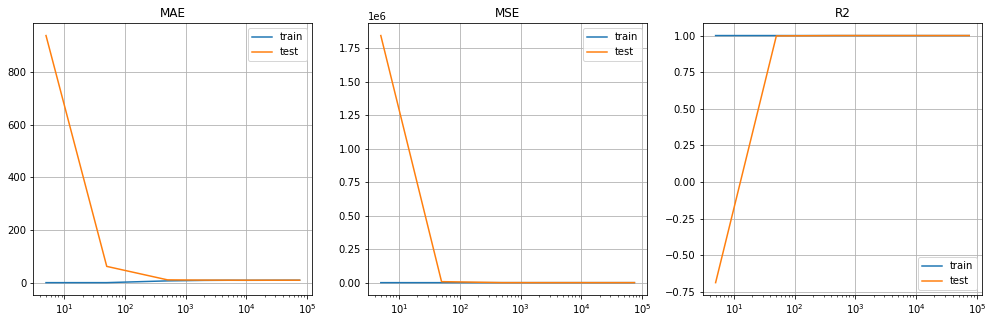

In [105]:
check_model(GradientBoostingRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), train['y1'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), test['y1'])

# SKLearn Regression on days + cash

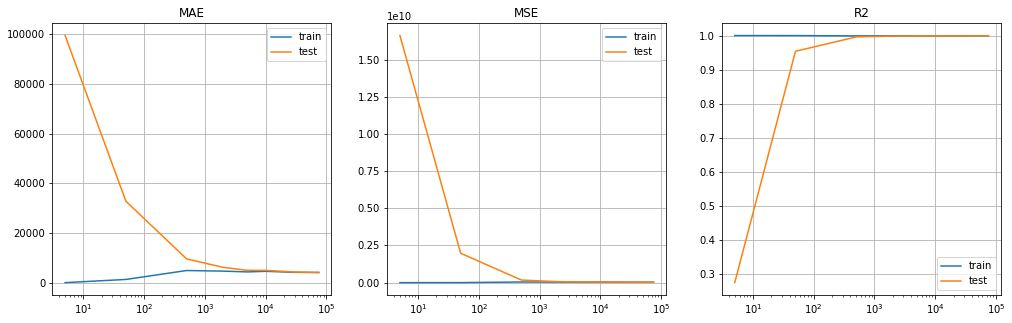

In [106]:
check_model(GradientBoostingRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), train['y2'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), test['y2'])

# SKLearn Regression on days + cash + marketdata

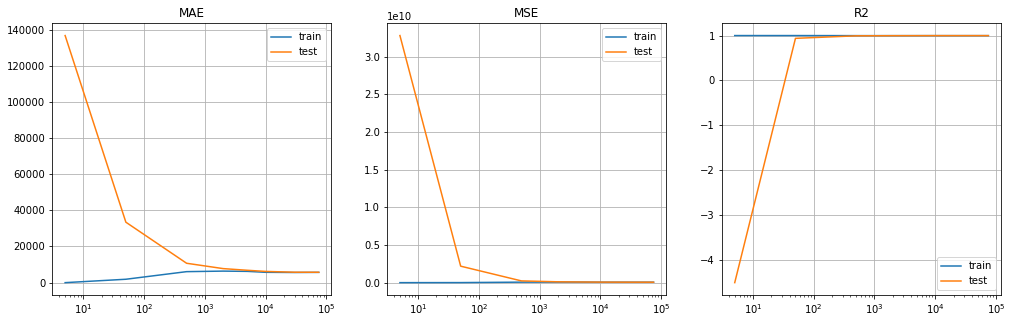

In [107]:
check_model(GradientBoostingRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), train['y3'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), test['y3'])

In [108]:
print('Cash STD in data:', np.std(df['cash']), 'Mean:', np.mean(df['cash']))

Cash STD in data: 288519.7588442623 Mean: 499580.75871


# KNN on days

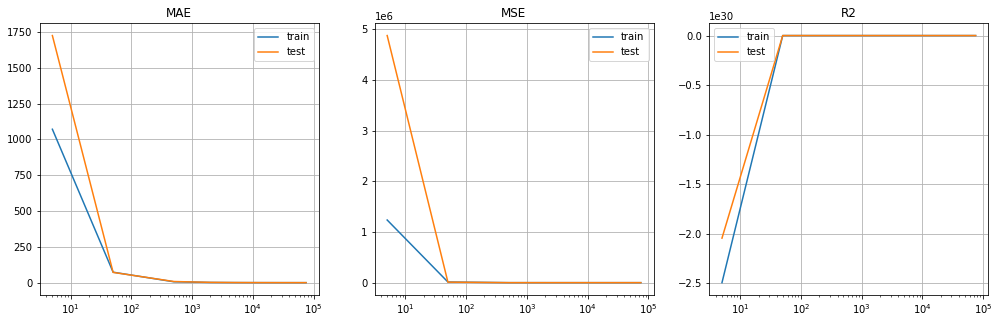

In [109]:
check_model(KNeighborsRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), train['y1'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash', 'marketdata']), test['y1'])

# KNN on days + cash

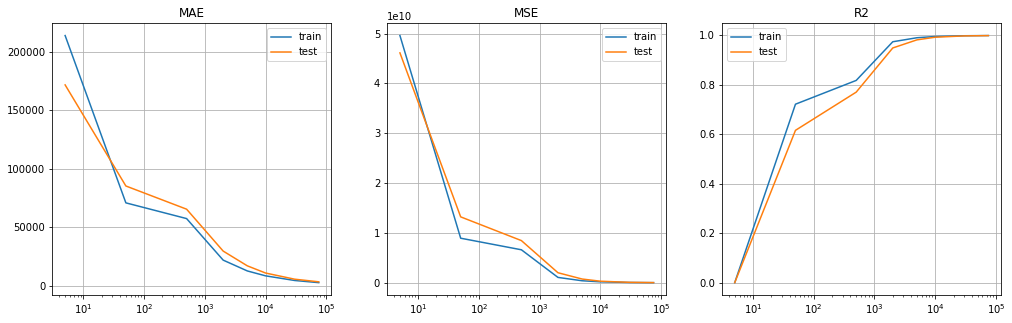

In [110]:
check_model(KNeighborsRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), train['y2'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata']), test['y2'])

# KNN on days + cash + marketdata

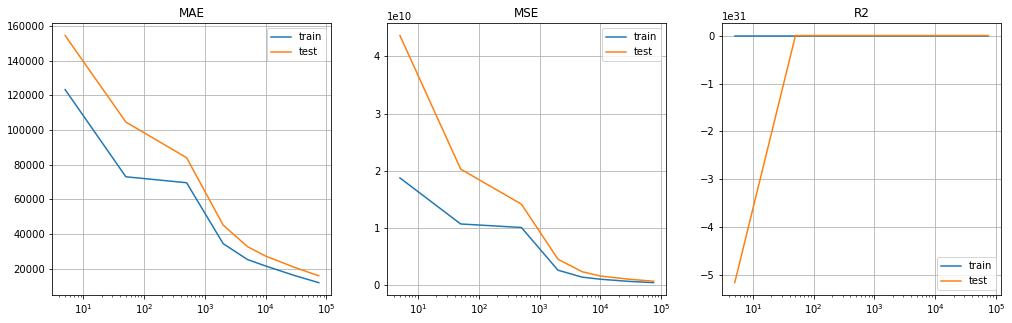

In [111]:
check_model(KNeighborsRegressor, train.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), train['y3'], 
           test.drop(columns=['y1', 'y2', 'y3', 'cash_const', 'marketdata_const']), test['y3'])

In [112]:
print('Cash STD in data:', np.std(df['cash']), 'Mean:', np.mean(df['cash']))

Cash STD in data: 288519.7588442623 Mean: 499580.75871


# SKLearn Boosting

In [45]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [46]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("MAE", mean_absolute_error(y_pred_train, y_train))
print("MAE test", mean_absolute_error(y_pred_test, y_test))
print()
print("MSE", mean_squared_error(y_pred_train, y_train))
print("MSE test", mean_squared_error(y_pred_test, y_test))
print()
print("R2", r2_score(y_pred_train, y_train))
print("R2 test", r2_score(y_pred_test, y_test))

MAE 6.9991912482631715
MAE test 6.973288504321172

MSE 122.8323153948564
MSE test 122.12510323133368

R2 0.9999693517832814
R2 test 0.9999696478830266


In [47]:
def generate_fake_deals(long_years=20, max_flows_number=20, max_cash_flow=1000000, marketdata=MARKETDATA):
    flows_number = int(random.random() * max_flows_number)
    due_days = np.minimum(long_years * 365 - 1, np.abs(np.random.normal(loc=0, scale=365 * long_years, size=flows_number).astype('int')))
    cash = np.ones(flows_number) * 10000
    # marketdata = np.array([marketdata[due_days[i] // 365] for i in range(len(due_days))])
    marketdata = np.ones(len(due_days)) * 0.05
    return due_days, cash, marketdata

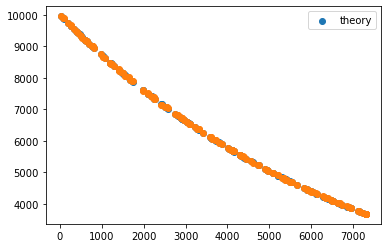

In [51]:
due_days, cash, marketdata = generate_fake_deals(20, 500)
y = np.array([np.exp(-marketdata[i] * due_days[i] / 365) * cash[i] for i in range(len(due_days))])

# print(due_days)

df_cur = pd.DataFrame({"due_days": due_days, 'cash': cash, 'marketdata':marketdata, 'y':y})

df.head(20)
preds = model.predict(df_cur.drop(columns=['y']))

plt.scatter(due_days, y, label='theory')
plt.scatter(due_days, preds)

plt.legend()

ValueError: x and y must be the same size

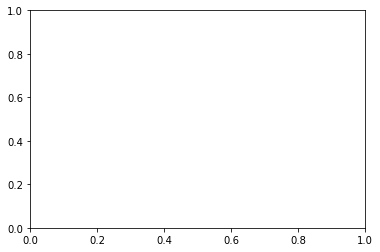

In [18]:
y_train_pred = model.predict(X_train)

plt.scatter(due_days, y_train, label='theory')
plt.scatter(due_days, y_train_pred)

plt.legend()

# KNN

In [52]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4, weights='distance')

In [57]:
y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

print("MAE", mean_absolute_error(y_pred_train, y_train))
print("MAE test", mean_absolute_error(y_pred_test, y_test))
print()
print("MSE", mean_squared_error(y_pred_train, y_train))
print("MSE test", mean_squared_error(y_pred_test, y_test))
print()
print("R2", r2_score(y_pred_train, y_train))
print("R2 test", r2_score(y_pred_test, y_test))

MAE 0.0
MAE test 0.0

MSE 0.0
MSE test 0.0

R2 1.0
R2 test 1.0


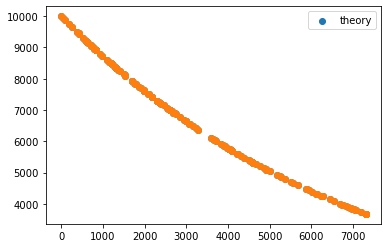

In [56]:
due_days, cash, marketdata = generate_fake_deals(20, 500)
y = np.array([np.exp(-marketdata[i] * due_days[i] / 365) * cash[i] for i in range(len(due_days))])

# print(due_days)

df_cur = pd.DataFrame({"due_days": due_days, 'cash': cash, 'marketdata':marketdata, 'y':y})

df.head(20)
preds = knn.predict(df_cur.drop(columns=['y']))

plt.scatter(due_days, y, label='theory')
plt.scatter(due_days, preds)

plt.legend()

#### Auto ML